In [1]:
#import statements
import datetime
import numpy as np
import pandas as pd
import plotly.graph_objects as go
import plotly.express as px
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

#from keypass import NOAA_api
import pylab as pl
from IPython import display

from functools import partial
import pyproj
from sklearn import datasets
from sklearn.tree import DecisionTreeRegressor
from sklearn.utils import shuffle
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score,explained_variance_score
from numpy import absolute
from numpy import mean
from numpy import std
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold

## $TCO_2$ will be target value of final model. The goal of the ML model will be to fill gaps in the dataset in which the target value is missing (~60% of rows). But first, input variables for this model must be made whole. 

First, the gaps in the input variables for the model need to be filled. The variables missing >5% of rows [gamma, oxygen, apparent O2 utilization, nitrate, silicate, phosphate, total alkilinity, pH] will be trained and tested with Linear Regression, Random Forest, and Decision Tree models (individually). 

The input variables for each column are cruise, station, cast, year, month, day, latitude, longitude, bottomdepth, maxsampledepth, pressure depth, temperature, theta, salinity and all sigma values. Rows missing values from these variables were removed before training. 

The best model is selected and saved to disk. The models are loaded to fill NA values in each row. 


In [2]:
df= pd.read_csv('C:\\Users\\ossan\\DATA606\\DATA\\cleanedFINAL.csv')
df

,cruise,station,cast,year,month,day,hour,minute,latitude,longitude,...,cfc11,pcfc11,cfc12,pcfc12,pcfc113,pccl4,psf6,Ocean Region,depthBinned,Date
0,1.0,319.0,1.0,1984.0,7.0,20.0,14.0,46.0,80.5670,7.2267,...,NaN,-9999.000000,NaN,-9999.000000,-9999.0,-9999.0,-9999.0,Arctic,< 200,1984-07-20
1,1.0,319.0,1.0,1984.0,7.0,20.0,14.0,46.0,80.5670,7.2267,...,NaN,-9999.000000,NaN,-9999.000000,-9999.0,-9999.0,-9999.0,Arctic,< 200,1984-07-20
2,1.0,319.0,1.0,1984.0,7.0,20.0,14.0,46.0,80.5670,7.2267,...,NaN,-9999.000000,NaN,-9999.000000,-9999.0,-9999.0,-9999.0,Arctic,< 200,1984-07-20
3,1.0,319.0,1.0,1984.0,7.0,20.0,14.0,46.0,80.5670,7.2267,...,NaN,-9999.000000,NaN,-9999.000000,-9999.0,-9999.0,-9999.0,Arctic,< 200,1984-07-20
4,1.0,319.0,1.0,1984.0,7.0,20.0,14.0,46.0,80.5670,7.2267,...,NaN,-9999.000000,NaN,-9999.000000,-9999.0,-9999.0,-9999.0,Arctic,< 200,1984-07-20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1253234,2103.0,6348.0,1.0,2018.0,9.0,14.0,10.0,8.0,-7.2578,162.0022,...,0.044,2.112996,0.0198,3.785733,-9999.0,-9999.0,-9999.0,Pacific,< 4000,2018-09-14
1253235,2103.0,6348.0,1.0,2018.0,9.0,14.0,10.0,8.0,-7.2578,162.0022,...,NaN,-9999.000000,NaN,-9999.000000,-9999.0,-9999.0,-9999.0,Pacific,< 4000,2018-09-14
1253236,2103.0,6348.0,1.0,2018.0,9.0,14.0,10.0,8.0,-7.2578,162.0022,...,0.020,0.932189,0.0033,0.614531,-9999.0,-9999.0,-9999.0,Pacific,< 4000,2018-09-14
1253237,2103.0,6348.0,1.0,2018.0,9.0,14.0,10.0,8.0,-7.2578,162.0022,...,0.000,0.000000,0.0000,0.000000,-9999.0,-9999.0,-9999.0,Pacific,< 4000,2018-09-14


## Steps before training to fill empty data
1. replace any column values with -9999 as np.nan
2. Dropping columns with nonrelevant features ie (hour, minute, etc) 
3. shuffle dataset
4. drop any rows with NA data to train ML models 
5. split to train, test, validation (60%, 20%, 20%) 

In [110]:
MLdata.columns 

Index(['cruise', 'station', 'cast', 'year', 'month', 'day', 'hour', 'minute',
       'latitude', 'longitude', 'bottomdepth', 'maxsampdepth', 'bottle',
       'pressure', 'depth', 'temperature', 'theta', 'salinity', 'sigma0',
       'sigma1', 'sigma2', 'sigma3', 'gamma', 'oxygen', 'aou', 'nitrate',
       'nitrite', 'silicate', 'phosphate', 'tco2', 'talk', 'fco2temp',
       'phts25p0', 'phtsinsitutp', 'cfc11', 'pcfc11', 'cfc12', 'pcfc12',
       'pcfc113', 'pccl4', 'psf6', 'Ocean Region', 'depthBinned', 'Date'],
      dtype='object')

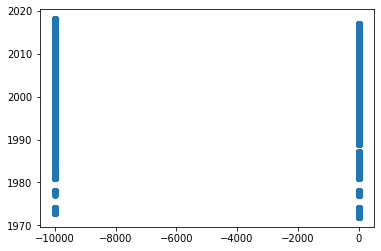

In [111]:
#fco2 is not useful input variable 
plt.scatter(MLdata['fco2temp'],MLdata['year']) #all zeros - drop 

In [5]:
# columns to drop - CFCs are assumed to be insignificant to tco2 modeling 

dropForVariableFill = ['minute','hour','Date','depthBinned','Ocean Region','fco2temp',
            'pcfc11','cfc11','cfc11','cfc12','pcfc12','pcfc113','pccl4','psf6','bottle','tco2']
d = ['minute','hour','Date','depthBinned','Ocean Region','fco2temp',
            'pcfc11','cfc11','cfc11','cfc12','pcfc12','pcfc113','pccl4','psf6','bottle']
#shuffle data, replace NAN
shuffled = shuffle(df.drop(columns=dropForVariableFill),random_state = 1)
shuffled=shuffled.replace(-9999.0,np.nan)

for i in shuffled.columns:
    a=shuffled[i].isna().sum()
    print(i,"{:0.2f} % rows NA ".format(100*a/len(shuffled)))
i=shuffled[shuffled.isna().any(axis=1)]


cruise 0.00 % rows NA 
station 0.00 % rows NA 
cast 0.01 % rows NA 
year 0.00 % rows NA 
month 0.00 % rows NA 
day 0.00 % rows NA 
latitude 0.00 % rows NA 
longitude 0.00 % rows NA 
bottomdepth 0.00 % rows NA 
maxsampdepth 0.01 % rows NA 
pressure 0.00 % rows NA 
depth 0.00 % rows NA 
temperature 0.58 % rows NA 
theta 2.69 % rows NA 
salinity 2.28 % rows NA 
sigma0 2.69 % rows NA 
sigma1 2.69 % rows NA 
sigma2 2.69 % rows NA 
sigma3 2.69 % rows NA 
gamma 12.64 % rows NA 
oxygen 13.97 % rows NA 
aou 15.16 % rows NA 
nitrate 23.53 % rows NA 
nitrite 41.23 % rows NA 
silicate 24.17 % rows NA 
phosphate 28.25 % rows NA 
talk 68.18 % rows NA 
phts25p0 80.15 % rows NA 
phtsinsitutp 80.14 % rows NA 


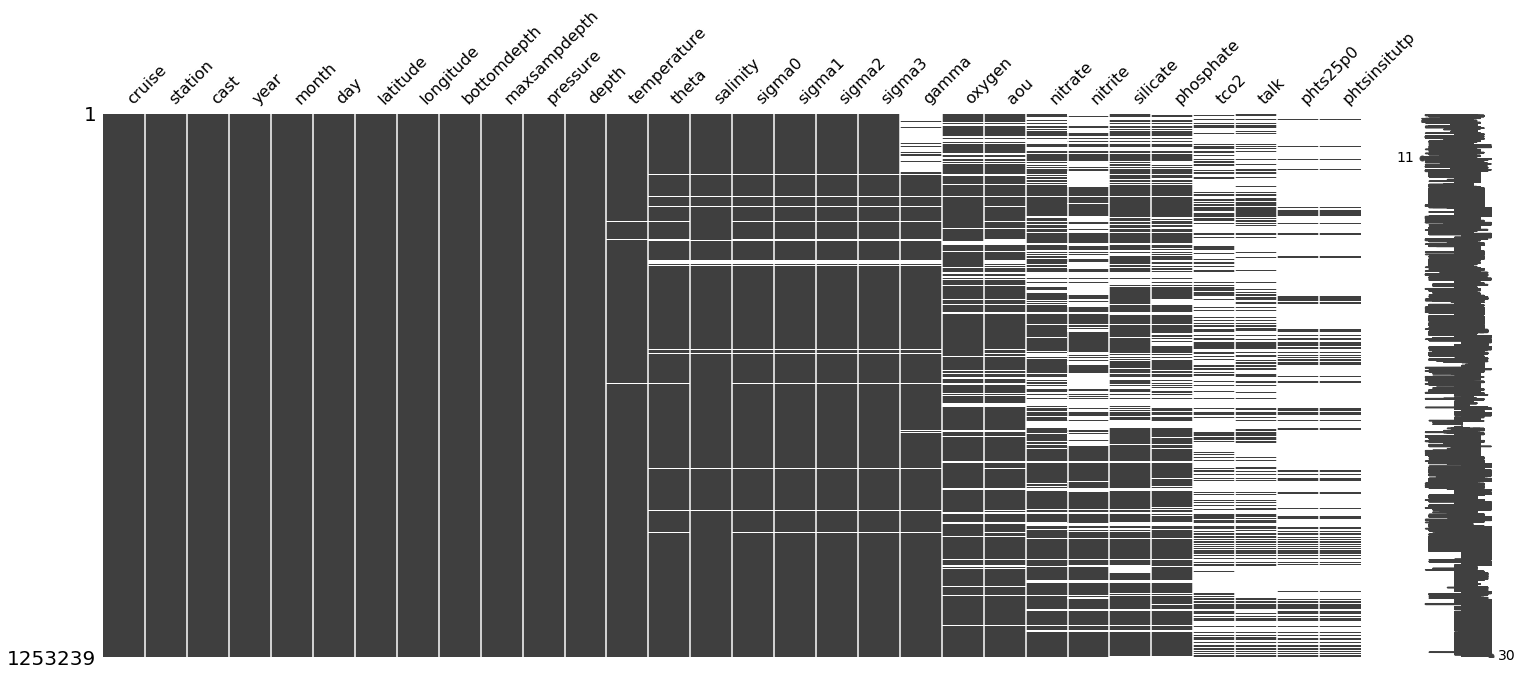

In [179]:
import missingno as msno ##show null rows 
MLdata=df.replace(-9999.0,np.nan)
msno.matrix(MLdata.drop(columns=d))

Text(0.5, 1, 'Correlation Matrix')

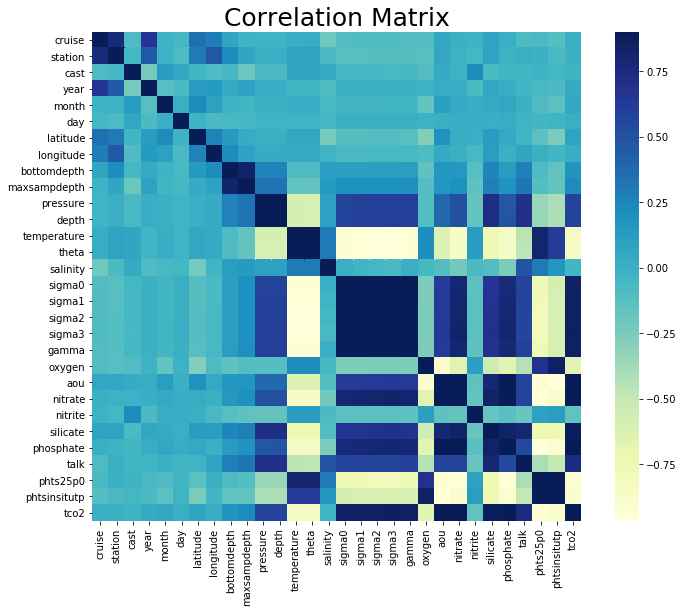

In [183]:
l=['cruise', 'station', 'cast', 'year', 'month', 'day', 'hour', 'minute',
       'latitude', 'longitude', 'bottomdepth', 'maxsampdepth', 'bottle',
       'pressure', 'depth', 'temperature', 'theta', 'salinity', 'sigma0',
       'sigma1', 'sigma2', 'sigma3', 'gamma', 'oxygen', 'aou', 'nitrate',
       'nitrite', 'silicate', 'phosphate', 'talk', 'fco2temp',
       'phts25p0', 'phtsinsitutp', 'cfc11', 'pcfc11', 'cfc12', 'pcfc12',
       'pcfc113', 'pccl4', 'psf6', 'Ocean Region', 'depthBinned', 'Date', 'tco2']
# Plot the Correlation map to see how features are correlated with target: SalePrice
i = MLdata[l]
corr_matrix = (i.drop(columns=d).dropna()).corr()
plt.subplots(figsize=(12,9))
sns.heatmap(corr_matrix, vmax=0.9, square=True,cmap="YlGnBu")
plt.title('Correlation Matrix',fontsize=25)

### Expectation- Fill the empties with model, input variables

cruise,station, year, month, day, latitude, longitude, bottomdepth, maxsampdepth, pressure, depth 

#### I will drop the rows missing values from the input variables with <5% missing [column & percent missing rows]
temperature, theta, salinity, sigma0, sigma1, sigma2, sigma3 

#### Fill these variables with ML model (random forest, decision tree, or linear regression) 

gamma, oxygen, aou, nitrate, nitrite, silicate, phosphate, talk, phts25p0, phtsinsitutp


In [6]:
#drop rows with any na 
FillVar = shuffled.dropna()

ratio = [.6,.2,.2]
#split to train, test validation sets 
train = FillVar.iloc[0:int(ratio[0]*FillVar.shape[0])]
test = FillVar.iloc[int(ratio[0]*FillVar.shape[0]):int((ratio[1]+ratio[0])*FillVar.shape[0])]
validation = FillVar.iloc[int((ratio[1]+ratio[0])*FillVar.shape[0]):(FillVar.shape[0])]
print('Total rows with all input variables ' + str(FillVar.shape[0]) +" training "+str(len(train))+ 
      " test " + str(len(test))+ " validation " +str(len(validation)))

Total rows with all input variables 136117 training 81670 test 27223 validation 27224


In [86]:
train.iloc[:,-10:len(train.columns)]
train.iloc[:,0:-10]
print(train.columns[0:-10])
print(train.columns[-10:len(train.columns)])

Index(['cruise', 'station', 'cast', 'year', 'month', 'day', 'latitude',
       'longitude', 'bottomdepth', 'maxsampdepth', 'pressure', 'depth',
       'temperature', 'theta', 'salinity', 'sigma0', 'sigma1', 'sigma2',
       'sigma3'],
      dtype='object')
Index(['gamma', 'oxygen', 'aou', 'nitrate', 'nitrite', 'silicate', 'phosphate',
       'talk', 'phts25p0', 'phtsinsitutp'],
      dtype='object')


### Test Decision tree, linear regression, and random forest. 
RF is best performing model for most to fill the empty input variables for later carbon dioxide modeling. 

In [7]:
#This function takes the data split input and trains and tests the dataset per column to 
#find metrics for decision tree (DT), linear regression (LR), and 
#random forest (RF) and return the R2, MSE, and explained variance (EVS) for each 
#column and model type 

def trainAndTest(train,test): 
    MSE,R2,EVS,MODEL,COL = [],[],[],[],[]
    DT = DecisionTreeRegressor(); LR = LinearRegression();  RF= RandomForestRegressor()
    #format the splits for multiple input/output regression training 
    inputsTRAIN=train.iloc[:,0:-10];outputsTRAIN=train.iloc[:,-10:len(train.columns)]
    inputsTEST=test.iloc[:,0:-10];outputsTEST=test.iloc[:,-10:len(train.columns)]
    inputsVAL=validation.iloc[:,0:-10];outputsVAL=validation.iloc[:,-10:len(train.columns)]
    
    print(inputsTRAIN.columns,outputsTRAIN.columns)
    for i in outputsTRAIN.columns:
        print(i) #check columns 
        #save lables ot arrays for dataframe output at end of function 
        for x in range(0,3): COL.append(i)
        MODEL.append('LR');MODEL.append('RF'); MODEL.append('DT')
        #fit models 
        LR.fit(inputsTRAIN,outputsTRAIN[i]); 
        DT.fit(inputsTRAIN,outputsTRAIN[i]); 
        RF.fit(inputsTRAIN,outputsTRAIN[i]); 
        #save metrics 
        MSE.append(mean_squared_error(outputsTEST[i], LR.predict(inputsTEST)))
        R2.append(r2_score(outputsTEST[i], LR.predict(inputsTEST)))
        EVS.append(explained_variance_score(outputsTEST[i], LR.predict(inputsTEST)))
        MSE.append(mean_squared_error(outputsTEST[i], RF.predict(inputsTEST)))
        R2.append(r2_score(outputsTEST[i], RF.predict(inputsTEST)))
        EVS.append(explained_variance_score(outputsTEST[i], RF.predict(inputsTEST)))
        MSE.append(mean_squared_error(outputsTEST[i], DT.predict(inputsTEST)))
        R2.append(r2_score(outputsTEST[i], DT.predict(inputsTEST)))
        EVS.append(explained_variance_score(outputsTEST[i], DT.predict(inputsTEST)))

    return pd.DataFrame(list(zip(MODEL,COL,MSE,R2,EVS)),columns=['Model','Column','MSE','R2','EVS'])

In [ ]:
traintest=trainAndTest(train,test)  #run the function to train/test LR DT and RF 
traintest.to_csv('C:\\Users\\ossan\\DATA606\\DATA\\variableMLscreen.csv') #save metrics 
traintest

### visuals of performance - fit is good so all metrics look similar 

In [9]:
traintest = pd.read_csv('C:\\Users\\ossan\\DATA606\\DATA\\variableMLscreen.csv') 

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), <a list of 10 Text xticklabel objects>)

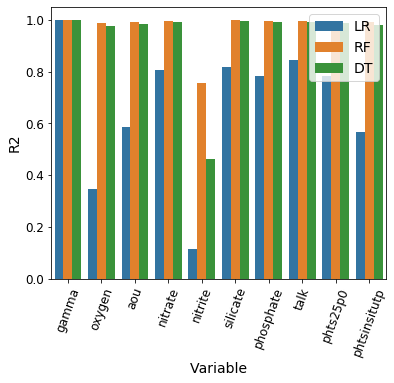

In [29]:
fig, ax= plt.subplots(1, 1,figsize=(6,5))
sns.barplot('Column','R2',ax=ax,data=traintest,hue='Model')
#sns.barplot('Column','MSE',ax=ax[2],data=traintest,hue='Model')
#sns.barplot('Column','EVS',ax=ax[1],data=traintest,hue='Model')

ax.set_ylabel('R2',fontsize=14)
#ax[2].set_ylabel('Mean Squared Error',fontsize=14);ax[1].set_ylabel('Explained Variance Score',fontsize=12)
ax.set_xlabel('')#;ax[1].set_xlabel('');
ax.set_xlabel('Variable',fontsize=14)
ax.legend(loc='upper right',fontsize=14)
plt.tick_params(labelsize=12)
plt.xticks(rotation=70)
#ax[2].axis('off');ax[1].axis('off')

### get the best performing model for each column

In [42]:
t=traintest.groupby('Column')
a,b = [],[]
for i, k in t: 
    k.sort_values('R2',ascending=False,inplace=True)
    a.append(k.iloc[0][0])
    b.append(k.iloc[0][1])

bestPerformance=pd.DataFrame(list(zip(a,b)),columns=['Best Model', 'Col'])
bestPerformance


,Best Model,Col
0,7,RF
1,2,DT
2,10,RF
3,13,RF
4,4,RF
5,19,RF
6,25,RF
7,28,RF
8,16,RF
9,22,RF


In [43]:
### this function takes the data split and trains the best model (RF) 
# for each column and saves the model to disk 

def trainAndSave(train,test,validation,startingCol): 
    MSE,R2,EVS,MODEL,COL = [],[],[],[],[]
    #DT = DecisionTreeRegressor(); LR = LinearRegression();  
    RF= RandomForestRegressor()
    #format the splits for multiple input/output regression training 
    inputsTRAIN=train.iloc[:,0:startingCol];outputsTRAIN=train.iloc[:,startingCol:len(train.columns)]
    inputsTEST=test.iloc[:,0:startingCol];outputsTEST=test.iloc[:,startingCol:len(train.columns)]
    inputsVAL=validation.iloc[:,0:startingCol];outputsVAL=validation.iloc[:,startingCol:len(train.columns)]
    
    print(inputsTRAIN.columns,outputsTRAIN.columns)
    for i in outputsTRAIN.columns:
        print(i)
        for x in range(0,2): COL.append(i)
        MODEL.append('Test');MODEL.append('Val')
        #LR.fit(inputsTRAIN,outputsTRAIN[i]); #DT.fit(inputsTRAIN,outputsTRAIN[i]); 
        RF.fit(inputsTRAIN,outputsTRAIN[i]); 
        #save test metrics 
        MSE.append(mean_squared_error(outputsTEST[i], RF.predict(inputsTEST)))
        R2.append(r2_score(outputsTEST[i], RF.predict(inputsTEST)))
        EVS.append(explained_variance_score(outputsTEST[i], RF.predict(inputsTEST)))
        #save validation metrics
        MSE.append(mean_squared_error(outputsVAL[i], RF.predict(inputsVAL)))
        R2.append(r2_score(outputsVAL[i], RF.predict(inputsVAL)))
        EVS.append(explained_variance_score(outputsVAL[i], RF.predict(inputsVAL)))
        #save model to computer #https://machinelearningmastery.com/save-load-machine-learning-models-python-scikit-learn/
        filename = 'C:\\Users\\ossan\\DATA606\\MODELS\\RF_COL_'+ i + '.sav'
        pickle.dump(RF, open(filename, 'wb'))

    return pd.DataFrame(list(zip(MODEL,COL,MSE,R2,EVS)),columns=['Set','Column','MSE','R2','EVS'])

In [44]:
saveRFmodels = trainAndSave(train,test,validation,-10)

Index(['cruise', 'station', 'cast', 'year', 'month', 'day', 'latitude',
       'longitude', 'bottomdepth', 'maxsampdepth', 'pressure', 'depth',
       'temperature', 'theta', 'salinity', 'sigma0', 'sigma1', 'sigma2',
       'sigma3'],
      dtype='object') Index(['gamma', 'oxygen', 'aou', 'nitrate', 'nitrite', 'silicate', 'phosphate',
       'talk', 'phts25p0', 'phtsinsitutp'],
      dtype='object')
gamma
oxygen
aou
nitrate
nitrite
silicate
phosphate
talk
phts25p0
phtsinsitutp


In [45]:
saveRFmodels.to_csv('C:\\Users\\ossan\\DATA606\\DATA\\NAperformance.csv') #save metrics 
saveRFmodels #model performace is fine 

,Set,Column,MSE,R2,EVS
0,Test,gamma,0.000644,0.999707,0.999707
1,Val,gamma,0.001886,0.999139,0.999139
2,Test,oxygen,62.129996,0.989093,0.989094
3,Val,oxygen,63.823260,0.988573,0.988573
4,Test,aou,62.937942,0.992991,0.992992
5,Val,aou,67.583363,0.992431,0.992431
6,Test,nitrate,0.820751,0.995932,0.995932
7,Val,nitrate,0.901516,0.995548,0.995548
8,Test,nitrite,0.008116,0.759470,0.759479
9,Val,nitrite,0.006421,0.693090,0.693180


#### Load in the saved ML models file location and fill the NA values in the dataset for ML training for the CO2 modeling

In [47]:
import os
#replace with your location 
folder = 'C:\\Users\\ossan\\DATA606\\MODELS\\'
files = os.listdir(folder) ; file = []
for f in files: 
    if f.find("_COL_")!=-1:
        file.append('C:\\Users\\ossan\\DATA606\\MODELS\\'+f)
file

['C:\\Users\\ossan\\DATA606\\MODELS\\RF_COL_aou.sav',
 'C:\\Users\\ossan\\DATA606\\MODELS\\RF_COL_gamma.sav',
 'C:\\Users\\ossan\\DATA606\\MODELS\\RF_COL_nitrate.sav',
 'C:\\Users\\ossan\\DATA606\\MODELS\\RF_COL_nitrite.sav',
 'C:\\Users\\ossan\\DATA606\\MODELS\\RF_COL_oxygen.sav',
 'C:\\Users\\ossan\\DATA606\\MODELS\\RF_COL_phosphate.sav',
 'C:\\Users\\ossan\\DATA606\\MODELS\\RF_COL_phts25p0.sav',
 'C:\\Users\\ossan\\DATA606\\MODELS\\RF_COL_phtsinsitutp.sav',
 'C:\\Users\\ossan\\DATA606\\MODELS\\RF_COL_silicate.sav',
 'C:\\Users\\ossan\\DATA606\\MODELS\\RF_COL_talk.sav']

In [117]:
print(NAfilled.columns[0:-10])
print(NAfilled.columns[-10:len(NAfilled)])


Index(['cruise', 'station', 'cast', 'year', 'month', 'day', 'latitude',
       'longitude', 'bottomdepth', 'maxsampdepth', 'pressure', 'depth',
       'temperature', 'theta', 'salinity', 'sigma0', 'sigma1', 'sigma2',
       'sigma3'],
      dtype='object')
Index(['gamma', 'oxygen', 'aou', 'nitrate', 'nitrite', 'silicate', 'phosphate',
       'talk', 'phts25p0', 'phtsinsitutp'],
      dtype='object')


In [156]:
#test pickle load 
RF = pickle.load(open(file[0],'rb'))
RF.predict(df_NAfill.iloc[:,0:-11])

array([-13.10406669, -11.67246744,  -8.41546315, ..., 205.05113941,
       205.71553084, 204.85692209])

### Remove all rows with empty input variables to fill NA rows (same filter applied before training). 

Add back in tco2 for later export, and reorder the columns so that tco2 is at the end of the dataframe. 

In [139]:
d = ['minute','hour','Date','depthBinned','Ocean Region','fco2temp',
            'pcfc11','cfc11','cfc11','cfc12','pcfc12','pcfc113','pccl4','psf6','bottle']

In [169]:
#repeat data load but keep tco2 for later 
dfNAfill = MLdata.drop(columns=d)
dfNAfill=dfNAfill.replace(-9999.0,np.nan)

reorder=['cruise', 'station', 'cast', 'year', 'month', 'day', 'latitude',
       'longitude', 'bottomdepth', 'maxsampdepth', 'pressure', 'depth',
       'temperature', 'theta', 'salinity', 'sigma0', 'sigma1', 'sigma2',
       'sigma3', 'gamma', 'oxygen', 'aou', 'nitrate', 'nitrite', 'silicate',
       'phosphate',  'talk', 'phts25p0', 'phtsinsitutp','tco2']

dfFill=dfNAfill[reorder]

df_NAfill= dfFill
for x in df_NAfill.columns[0:-11]:
    df_NAfill.dropna(subset=[x],inplace=True)
print('rows to fill na data: ' +str(len(df_NAfill)))
print(df_NAfill.isnull().sum())

rows to fill na data: 1218966
cruise               0
station              0
cast                 0
year                 0
month                0
day                  0
latitude             0
longitude            0
bottomdepth          0
maxsampdepth         0
pressure             0
depth                0
temperature          0
theta                0
salinity             0
sigma0               0
sigma1               0
sigma2               0
sigma3               0
gamma           124357
oxygen          160507
aou             156161
nitrate         280904
nitrite         496140
silicate        289926
phosphate       334351
talk            824739
phts25p0        971468
phtsinsitutp    971216
tco2            784505
dtype: int64


In [170]:
#check alignment 
print(df_NAfill.columns[-11:len(df_NAfill.columns)-1])
df_NAfill.columns[0:-11]

Index(['gamma', 'oxygen', 'aou', 'nitrate', 'nitrite', 'silicate', 'phosphate',
       'talk', 'phts25p0', 'phtsinsitutp'],
      dtype='object')


Index(['cruise', 'station', 'cast', 'year', 'month', 'day', 'latitude',
       'longitude', 'bottomdepth', 'maxsampdepth', 'pressure', 'depth',
       'temperature', 'theta', 'salinity', 'sigma0', 'sigma1', 'sigma2',
       'sigma3'],
      dtype='object')

In [171]:
pd.options.mode.chained_assignment = None  # default='warn'

# this function takes the list of saved models and the dataframe to fill NA values 
def fillNA(df,file,COL):
    a={} #make a dictionary 
    # for columns to have NAs filled, subtract one for tco2 
    for i in df.columns[COL:(len(df.columns)-1)]:
        df_missing = df[df[i].isna()]#get rows will missing values in column
        #print(df_missing.columns[COL:(len(df_missing.columns)-1)])
        #print(df_missing.columns[0:COL])
       # for each model if the name matches column open the model and predict 
       #missing values and save to dictionary 
        for x in file: 
            if x.find(i)!=-1:
                print(x) # print modle 
                loaded_RF = pickle.load(open(x, 'rb'))
                df_missing[i] = loaded_RF.predict(df_missing.iloc[:,0:COL])
                a[i] = df_missing[i]
    # for each column filled in the dictionary 
    #find matching row in dataframe and fill the NA value 
    # return the filled dataframe 
    for key,group in a.items(): 
        for indexFill,row1 in group.iteritems():
            df.loc[indexFill,key] = row1
    return df


NAfilled=fillNA(df_NAfill,file,-11)
NAfilled

Index(['gamma', 'oxygen', 'aou', 'nitrate', 'nitrite', 'silicate', 'phosphate',
       'talk', 'phts25p0', 'phtsinsitutp'],
      dtype='object')
Index(['cruise', 'station', 'cast', 'year', 'month', 'day', 'latitude',
       'longitude', 'bottomdepth', 'maxsampdepth', 'pressure', 'depth',
       'temperature', 'theta', 'salinity', 'sigma0', 'sigma1', 'sigma2',
       'sigma3'],
      dtype='object')
C:\Users\ossan\DATA606\MODELS\RF_COL_gamma.sav
Index(['gamma', 'oxygen', 'aou', 'nitrate', 'nitrite', 'silicate', 'phosphate',
       'talk', 'phts25p0', 'phtsinsitutp'],
      dtype='object')
Index(['cruise', 'station', 'cast', 'year', 'month', 'day', 'latitude',
       'longitude', 'bottomdepth', 'maxsampdepth', 'pressure', 'depth',
       'temperature', 'theta', 'salinity', 'sigma0', 'sigma1', 'sigma2',
       'sigma3'],
      dtype='object')
C:\Users\ossan\DATA606\MODELS\RF_COL_oxygen.sav
Index(['gamma', 'oxygen', 'aou', 'nitrate', 'nitrite', 'silicate', 'phosphate',
       'talk', 'pht

,cruise,station,cast,year,month,day,latitude,longitude,bottomdepth,maxsampdepth,...,oxygen,aou,nitrate,nitrite,silicate,phosphate,talk,phts25p0,phtsinsitutp,tco2
0,1.0,319.0,1.0,1984.0,7.0,20.0,80.5670,7.2267,733.0,724.0,...,364.4217,41.127412,6.999854,0.173044,11.528207,0.716996,2246.51600,7.755562,8.097094,NaN
1,1.0,319.0,1.0,1984.0,7.0,20.0,80.5670,7.2267,733.0,724.0,...,368.4407,40.088912,6.296140,0.174173,11.894017,0.697710,2248.61700,7.755862,8.100389,NaN
2,1.0,319.0,1.0,1984.0,7.0,20.0,80.5670,7.2267,733.0,724.0,...,317.7117,74.733536,10.337344,0.321031,13.978075,0.736596,2299.57100,7.730416,8.074687,NaN
3,1.0,319.0,1.0,1984.0,7.0,20.0,80.5670,7.2267,733.0,724.0,...,317.7117,74.733536,10.520583,0.321031,19.082168,0.738266,2299.62000,7.727801,8.074700,NaN
4,1.0,319.0,1.0,1984.0,7.0,20.0,80.5670,7.2267,733.0,724.0,...,313.3172,17.221862,11.760565,0.444700,9.182778,0.807504,2311.06500,7.736636,8.066457,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1253234,2103.0,6348.0,1.0,2018.0,9.0,14.0,-7.2578,162.0022,1533.4,1523.4,...,118.6000,198.117946,36.700000,0.000000,84.545830,2.627777,2354.78825,7.540000,7.796394,2287.7
1253235,2103.0,6348.0,1.0,2018.0,9.0,14.0,-7.2578,162.0022,1533.4,1523.4,...,118.3000,198.415326,36.730000,0.000000,84.647600,2.627777,2357.80000,7.539500,7.795944,2287.0
1253236,2103.0,6348.0,1.0,2018.0,9.0,14.0,-7.2578,162.0022,1533.4,1523.4,...,118.8000,201.673756,37.070000,0.000000,95.290630,2.628687,2367.10000,7.539100,7.794708,2299.5
1253237,2103.0,6348.0,1.0,2018.0,9.0,14.0,-7.2578,162.0022,1533.4,1523.4,...,117.9000,206.729280,37.480000,0.000000,107.824800,2.624351,2384.40000,7.535800,7.790786,2314.4


In [172]:
#checking output 
print(NAfilled.isnull().sum())
print(len(NAfilled))

cruise               0
station              0
cast                 0
year                 0
month                0
day                  0
latitude             0
longitude            0
bottomdepth          0
maxsampdepth         0
pressure             0
depth                0
temperature          0
theta                0
salinity             0
sigma0               0
sigma1               0
sigma2               0
sigma3               0
gamma                0
oxygen               0
aou                  0
nitrate              0
nitrite              0
silicate             0
phosphate            0
talk                 0
phts25p0             0
phtsinsitutp         0
tco2            784505
dtype: int64
1218966


## Unshuffle and export the filled dataset to csv for use in the next notebook. 

Reprint correlation matrix. 

In [173]:
NAfilled=NAfilled.sort_index()
NAfilled

,cruise,station,cast,year,month,day,latitude,longitude,bottomdepth,maxsampdepth,...,oxygen,aou,nitrate,nitrite,silicate,phosphate,talk,phts25p0,phtsinsitutp,tco2
0,1.0,319.0,1.0,1984.0,7.0,20.0,80.5670,7.2267,733.0,724.0,...,364.4217,41.127412,6.999854,0.173044,11.528207,0.716996,2246.51600,7.755562,8.097094,NaN
1,1.0,319.0,1.0,1984.0,7.0,20.0,80.5670,7.2267,733.0,724.0,...,368.4407,40.088912,6.296140,0.174173,11.894017,0.697710,2248.61700,7.755862,8.100389,NaN
2,1.0,319.0,1.0,1984.0,7.0,20.0,80.5670,7.2267,733.0,724.0,...,317.7117,74.733536,10.337344,0.321031,13.978075,0.736596,2299.57100,7.730416,8.074687,NaN
3,1.0,319.0,1.0,1984.0,7.0,20.0,80.5670,7.2267,733.0,724.0,...,317.7117,74.733536,10.520583,0.321031,19.082168,0.738266,2299.62000,7.727801,8.074700,NaN
4,1.0,319.0,1.0,1984.0,7.0,20.0,80.5670,7.2267,733.0,724.0,...,313.3172,17.221862,11.760565,0.444700,9.182778,0.807504,2311.06500,7.736636,8.066457,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1253234,2103.0,6348.0,1.0,2018.0,9.0,14.0,-7.2578,162.0022,1533.4,1523.4,...,118.6000,198.117946,36.700000,0.000000,84.545830,2.627777,2354.78825,7.540000,7.796394,2287.7
1253235,2103.0,6348.0,1.0,2018.0,9.0,14.0,-7.2578,162.0022,1533.4,1523.4,...,118.3000,198.415326,36.730000,0.000000,84.647600,2.627777,2357.80000,7.539500,7.795944,2287.0
1253236,2103.0,6348.0,1.0,2018.0,9.0,14.0,-7.2578,162.0022,1533.4,1523.4,...,118.8000,201.673756,37.070000,0.000000,95.290630,2.628687,2367.10000,7.539100,7.794708,2299.5
1253237,2103.0,6348.0,1.0,2018.0,9.0,14.0,-7.2578,162.0022,1533.4,1523.4,...,117.9000,206.729280,37.480000,0.000000,107.824800,2.624351,2384.40000,7.535800,7.790786,2314.4


In [174]:
NAfilled.to_csv('C:\\Users\\ossan\\DATA606\\DATA\\filledNArows.csv') #save metrics 


Text(0.5, 1, 'Correlation Matrix with Filled NA')

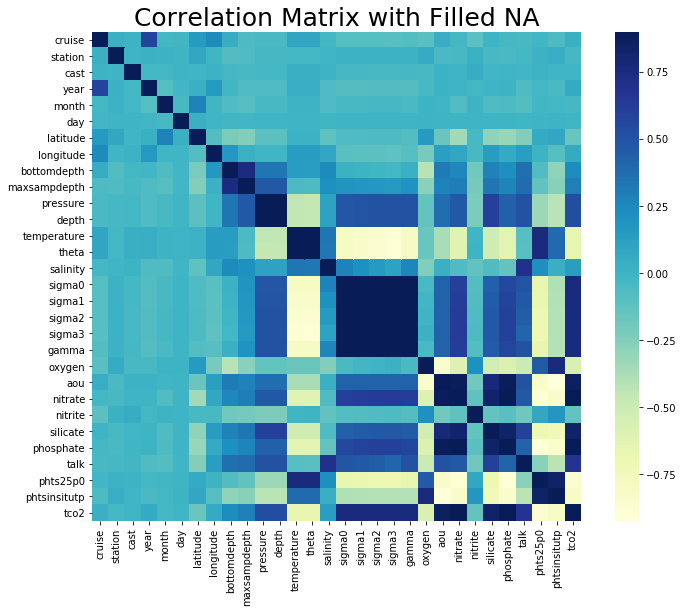

In [175]:

# Plot the Correlation map to see how features are correlated with target: SalePrice
corr_matrix = (NAfilled.dropna()).corr()
plt.subplots(figsize=(12,9))
sns.heatmap(corr_matrix, vmax=0.9, square=True,cmap="YlGnBu")
plt.title('Correlation Matrix with Filled NA',fontsize=25)

In [194]:

import imageio
images = []
filenames = ['C:\\Users\\ossan\\DATA606\\corrMatrix.png','C:\\Users\\ossan\\DATA606\\afterNAfilled.png']
for filename in filenames:
    images.append(imageio.imread(filename))
imageio.mimsave('C:\\Users\\ossan\\DATA606\\corr.gif', images,format='GIF',duration=2)
